# Unamortised VAE test

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../experiments/")
import base_vae_hardem

In [4]:
import os

os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_VISIBLE_DEVICES"] = "0"

In [5]:
import jax
import hlax
import tomli
import distrax
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt

In [6]:
%config InlineBackend.figure_format = "retina"

In [1196]:
def build_mll_summary(res, procedure):
    df_mll = pd.DataFrame(res["test"]["mll_epochs"]).melt(var_name="episode", value_name="mll")
    df_mll["procedure"] = procedure

    df_times = pd.DataFrame.from_dict({"times": res["train"]["times"]}, orient="index").T
    df_mll = pd.merge(df_mll, df_times, left_on="episode", right_index=True)
    return df_mll

## Loss functions

In [1499]:
def iwae_bern(key, params, apply_fn, X_batch):
    """
    Importance-weighted marginal log-likelihood for
    a Bernoulli decoder
    """
    batch_size = len(X_batch)

    # keys = jax.random.split(key, batch_size)
    # encode_decode = jax.vmap(apply_fn, (None, 0, 0))
    # encode_decode = encode_decode(params, X_batch, keys)
    encode_decode = apply_fn(params, X_batch, key)
    z, (mean_z, logvar_z), logit_mean_x = encode_decode
    _, num_is_samples, dim_latent = z.shape

    std_z = jnp.exp(logvar_z / 2)
    
    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent),
                                                jnp.ones(dim_latent))
    dist_decoder = distrax.Bernoulli(logits=logit_mean_x)
    dist_posterior = distrax.Normal(mean_z[None, ...], std_z[None, ...])

    log_prob_z_prior = dist_prior.log_prob(z)
    log_prob_x = dist_decoder.log_prob(X_batch).sum(axis=-1)
    log_prob_z_post = dist_posterior.log_prob(z).sum(axis=-1)

    log_prob = log_prob_z_prior + log_prob_x - log_prob_z_post

    # negative Importance-weighted marginal log-likelihood
    niwmll = -jax.nn.logsumexp(log_prob, axis=-1, b=1/num_is_samples).mean()
    return niwmll


def hard_nmll_bern(params, z_batch, X_batch, model):
    """
    Loss function
    -------------

    Negative Marginal log-likelihood for hard EM
    assuming an isotropic Gaussian prior with zero mean
    and a decoder with a diagonal covariance matrix

    Parameters
    ----------
    params: pytree
        Parameters of the decoder model, i.e.,
        model.apply(params, z_batch) = X_batch (approx)
    z_batch: jnp.ndarray
        Batch of latent variables
    X_batch: jnp.ndarray
        Batch of observations
    model: flax.nn.Module
        Decoder model (input z -> output x)
    """
    dim_latent = model.dim_latent

    logit_mean_x = model.apply(params, z_batch)

    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent), jnp.ones(dim_latent))
    dist_decoder = distrax.Bernoulli(logits=logit_mean_x)

    log_prob_z_prior = dist_prior.log_prob(z_batch)
    log_prob_x = dist_decoder.log_prob(X_batch).sum(axis=-1)

    log_prob = log_prob_z_prior + log_prob_x

    return -log_prob.mean()


def neg_iwmll_bern(key, params_encoder, params_decoder, observation,
              encoder, decoder, num_is_samples=10):
    """
    Importance-weighted marginal log-likelihood for an unamortised, uncoditional
    gaussian encoder.
    """
    latent_samples, (mu_z, std_z) = encoder.apply(
        params_encoder, key, num_samples=num_is_samples
    )

    _, dim_latent = latent_samples.shape
    # log p(x|z)
    logit_mean_x = decoder.apply(params_decoder, latent_samples)
    log_px_cond = distrax.Bernoulli(logits=logit_mean_x).log_prob(observation).sum(axis=-1)

    # log p(z)
    mu_z_init, std_z_init = jnp.zeros(dim_latent), jnp.ones(dim_latent)
    log_pz = distrax.MultivariateNormalDiag(mu_z_init, std_z_init).log_prob(latent_samples)

    # log q(z)
    log_qz = distrax.MultivariateNormalDiag(mu_z, std_z).log_prob(latent_samples)

    # Importance-weighted marginal log-likelihood
    log_prob = log_pz + log_px_cond - log_qz
    niwmll = -jax.nn.logsumexp(log_prob, axis=-1, b=1/num_is_samples)
    return niwmll



def neg_iwmll_bern_delta(key, params_encoder, params_decoder, observation,
              encoder, decoder, num_is_samples=10):
    """
    Importance-weighted marginal log-likelihood for an unamortised, uncoditional
    gaussian encoder.
    """
    latent_samples = encoder.apply(
        params_encoder, key
    )
    
    import pdb; pdb.set_trace()
    logit_mean_x = decoder.apply(params_decoder, latent_samples)
    
    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent), jnp.ones(dim_latent))
    dist_decoder = distrax.Bernoulli(logits=logit_mean_x)
    
    log_prob_z_prior = dist_prior.log_prob(latent_samples)
    log_prob_x = dist_decoder.log_prob(observation).sum(axis=-1)

    log_prob = log_prob_z_prior + log_prob_x

    return -log_prob.mean()

## Models

In [1453]:
from typing import Callable

class Decoder(nn.Module):
    """
    For the generative model
    p(x,z) = p(x|z) * p(z)
    """
    dim_full: int
    dim_latent: int = 20
    
    def setup(self):
        self.logit = nn.Dense(self.dim_full, use_bias=True, name="mean")
    
    @nn.compact
    def __call__(self, z):
        x = nn.Dense(100)(z)
        x = nn.elu(x)
        x = nn.Dense(50)(x)
        x = nn.elu(x)
        logit_x = self.logit(x)
        return logit_x


class Encoder(nn.Module):
    """
    two-layered encoder
    """
    latent_dim: int
    n_hidden: int = 100
    
    @nn.compact
    def __call__(self, x):
        z = nn.Dense(self.n_hidden)(x)
        z = nn.elu(z)
        z = nn.Dense(self.n_hidden)(z)
        z = nn.elu(z)
        z = nn.Dense(self.n_hidden)(z)
        z = nn.elu(z)
        z = nn.Dense(self.n_hidden)(z)
        z = nn.elu(z)
        mean_z = nn.Dense(self.latent_dim)(z)
        logvar_z = nn.Dense(self.latent_dim)(z)
        return mean_z, logvar_z
    
    
class GaussEncoder(nn.Module):
    dim_latent: int
    normal_init: Callable = nn.initializers.normal()

    def setup(self):
        self.mu = self.param("mu", self.normal_init, (self.dim_latent,))
        self.logvar_diag = self.param("logvar_diag", self.normal_init, (self.dim_latent,))

    def __call__(self, _):
        """
        Input x (_) is a dummy variable
        """
        return self.mu, self.logvar_diag

## Setup

In [1454]:
batch_size = 200
key = jax.random.PRNGKey(314)
warmup, test = hlax.datasets.load_fashion_mnist(n_train=1_000, n_test=100, normalize=False)
X_warmup = warmup[0].round()
X_test = test[0].round()

In [1455]:
dim_latent = 50
num_obs, *dim_obs = X_warmup.shape

In [1456]:
path_config = "../experiments/configs/fmnist-conv01.toml"
with open(path_config, "rb") as f:
    config_str = f.read().decode("utf-8")
    config = tomli.loads(config_str)

print(config_str)

# TOML file for a fashion mnist dataset
[setup]
dim_latent = 50

[train]
    num_obs = 10_000
    num_epochs = 3000
    batch_size = 200
    eval_epochs = [2, 10, 100, 250, 500, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2500, 3000]
    learning_rate = 1e-6 # For VAE and HardEM

    [train.vae]
        num_is_samples = 10
    [train.hard_em]
        num_its_latent = 10 # E-step
        num_its_params = 5 # M-step

[test]
    num_obs = 1000
    num_epochs = 500
    learning_rate = 1e-6
    num_is_samples = 10


In [1457]:
config["train"]["learning_rate"] = 1e-4
config["train"]["hard_em"]["num_its_latent"] = 5
config["train"]["hard_em"]["num_its_params"] = 5
config["train"]["num_epochs"] = 1000
config["train"]["eval_epochs"] = list(range(0, 1000 + 50, 50))

In [1509]:
model_decoder = Decoder(28 ** 2, dim_latent)

model_encoder_test = hlax.models.GaussEncoder(dim_latent)
grad_neg_iwmll_encoder = jax.value_and_grad(neg_iwmll_bern, argnums=1)
vmap_neg_iwmll = jax.vmap(neg_iwmll_bern, (0, 0, None, 0, None, None, None))

# model_encoder_test = DeltaEncoder(dim_latent)
# grad_neg_iwmll_encoder = jax.value_and_grad(neg_iwmll_bern_delta, argnums=1)
# vmap_neg_iwmll = jax.vmap(neg_iwmll_bern_delta, (0, 0, None, 0, None, None, None))

In [1510]:
config_test = base_vae_hardem.load_test_config(config, model_encoder_test, model_decoder)

## Benchmark models

### VAE

In [1511]:
model_vae = hlax.models.VAEBern(dim_latent, dim_obs[0], Encoder, Decoder)
config_vae = hlax.vae.load_config(config, model_vae)

res_vae = base_vae_hardem.train_test(
    key,
    X_warmup,
    X_test,
    config_vae,
    config_test,
    iwae_bern,
    vmap_neg_iwmll,
    grad_neg_iwmll_encoder,
    hlax.vae.train_checkpoints
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [1537]:
state_final = res_vae["train"]["state_final"]
*_, vals = model_vae.apply(state_final.params, X_warmup, key, 10)
vals.shape

(10, 1000, 784)

In [1538]:
res_vae["test"]["mll_epochs"]["e50"].shape

(100,)

Text(0.5, 0.98, 'VAE')

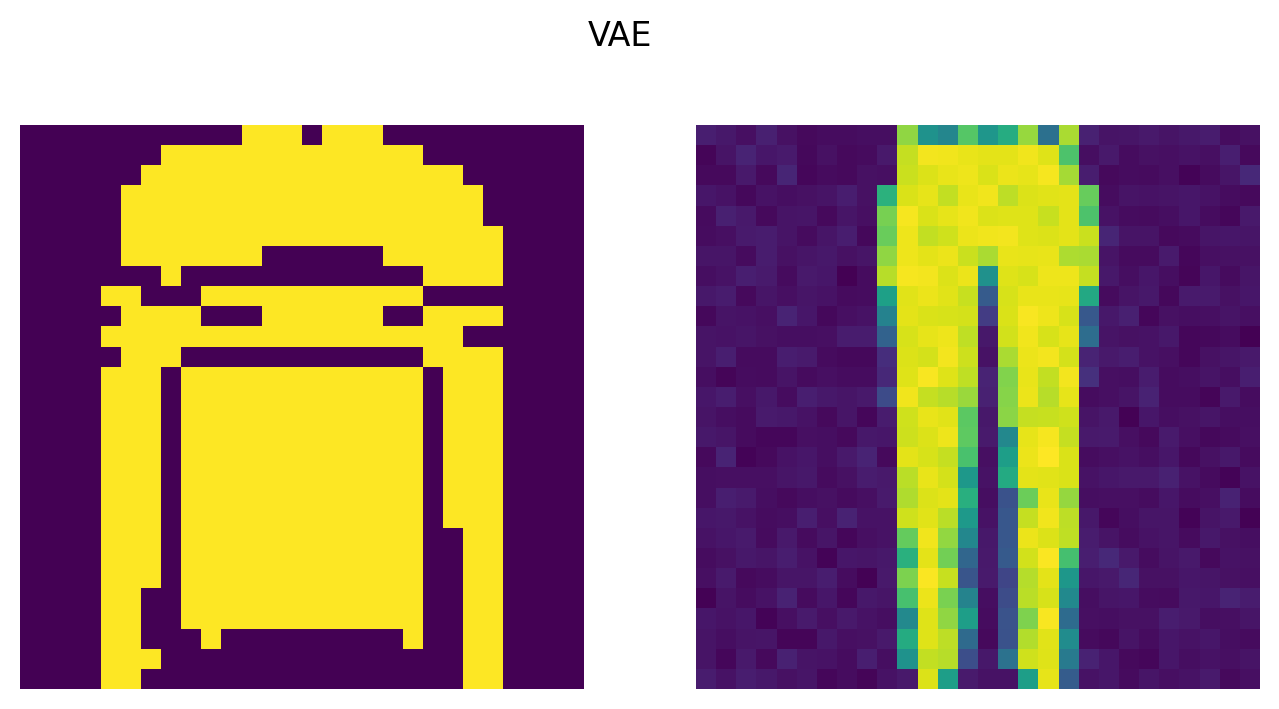

In [1542]:
ix_target = 5
img_reconstruct = vals[ix_target].reshape(-1, 28, 28)
img_reconstruct = nn.sigmoid(img_reconstruct).mean(axis=0)

img_target = X_warmup[ix_target].reshape(28, 28)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img_target)
ax[1].imshow(img_reconstruct)

ax[0].axis("off")
ax[1].axis("off")

plt.suptitle("VAE")

### Umamortised VAE

In [1515]:
%%time
model_uvae = hlax.models.UnamortisedVAEBern(dim_latent, dim_obs[0], GaussEncoder, Decoder)
config_uvae = hlax.unamortised.load_config(config, model_uvae)

res_uvae = base_vae_hardem.train_test(
    key,
    X_warmup,
    X_test,
    config_uvae,
    config_test,
    iwae_bern,
    vmap_neg_iwmll,
    grad_neg_iwmll_encoder,
    hlax.unamortised.train_checkpoints
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 40.6 s, sys: 8.45 s, total: 49 s
Wall time: 41.1 s


Text(0.5, 0.98, 'Unconditional, unamortised encoder')

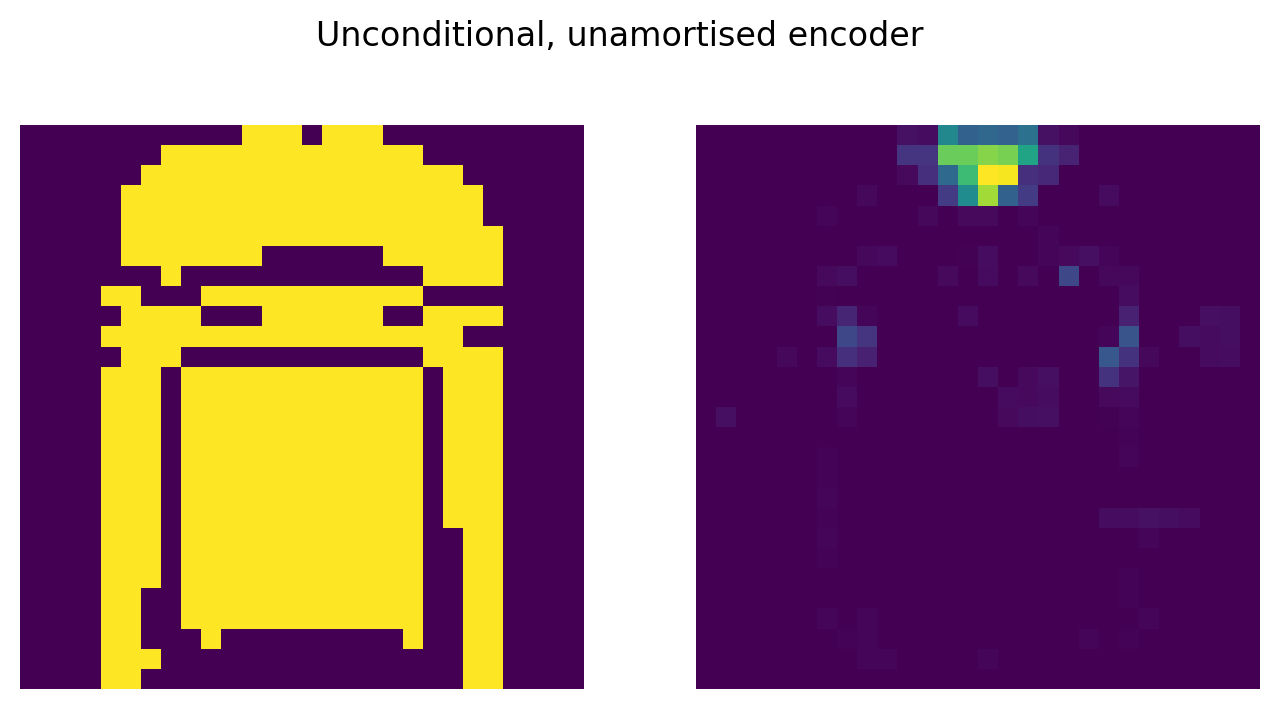

In [1547]:
state_final = res_uvae["train"]["state_final"]
params_hemv2 = state_final.params
vals = model_uvae.apply(params_hemv2, X_warmup, key)[-1][0]

ix_target = 5
img_reconstruct = vals[ix_target].reshape(28, 28)
img_reconstruct = nn.sigmoid(img_reconstruct)

img_target = X_warmup[ix_target].reshape(28, 28)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img_target)
ax[1].imshow(img_reconstruct)

ax[0].axis("off")
ax[1].axis("off")


plt.suptitle("Unconditional, unamortised encoder")

### Hard-EM LVM

In [1517]:
%%time
# Decoder model
model_hem = Decoder(28 ** 2, dim_latent)
config_hem = hlax.hard_em_lvm.load_config(config, model_hem)

res_hem = base_vae_hardem.train_test(
    key,
    X_warmup,
    X_test,
    config_hem,
    config_test,
    hard_nmll_bern,
    vmap_neg_iwmll,
    grad_neg_iwmll_encoder,
    hlax.hard_em_lvm.train_checkpoints
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 35.3 s, sys: 8.87 s, total: 44.2 s
Wall time: 26.2 s


Text(0.5, 0.98, 'Hard-EM (original / train)')

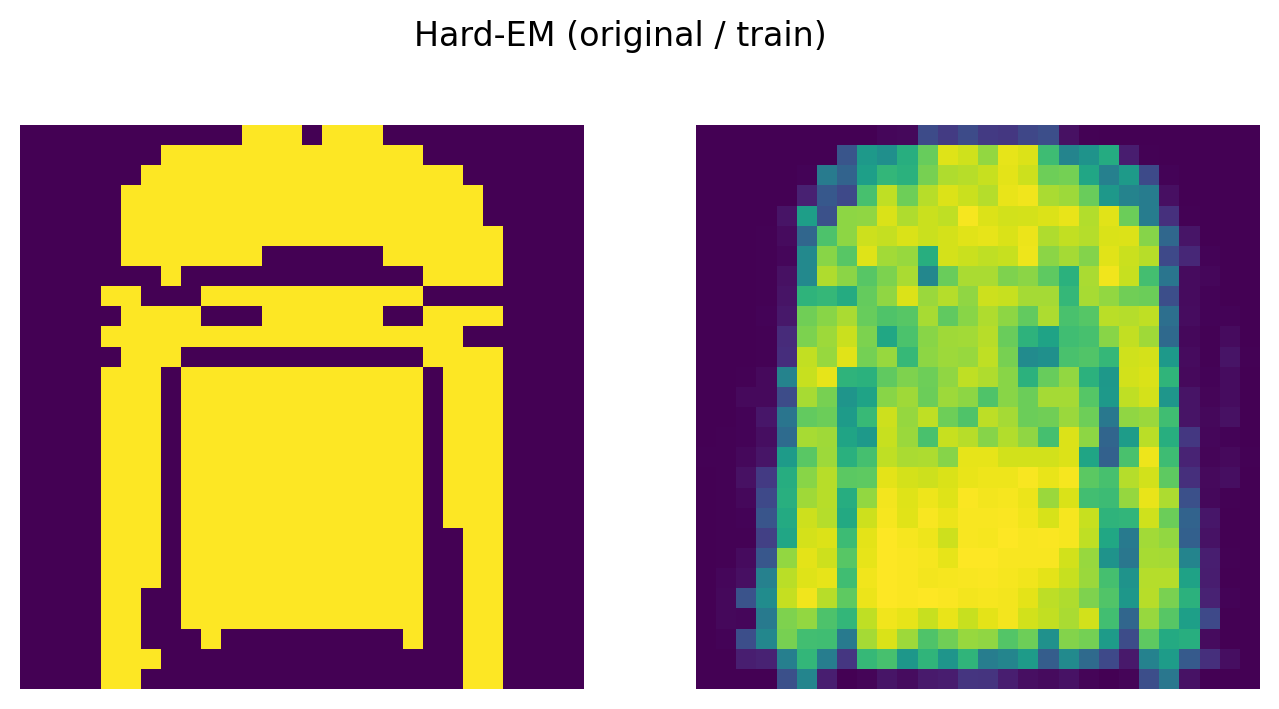

In [1527]:
state_final = res_hem["train"]["state_final"]
params_decoder, z_est = state_final

vals = model_hem.apply(params_decoder, z_est)

ix_target = 5
img_reconstruct = nn.sigmoid(vals[ix_target]).reshape(28, 28)
img_target = X_warmup[ix_target].reshape(28, 28)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(img_target)
ax[1].imshow(img_reconstruct)

ax[0].axis("off")
ax[1].axis("off")

plt.suptitle("Hard-EM (original / train)")

### Hard-EM unamortised (testing API)

In [1520]:
class UnamortisedVAEBernDelta(nn.Module):
    """
    Base class for an unamortised variational autoencoder
    with Bernoulli decoder p(x|z) = Bern(x| f(z))
    and Dirac-delta encoder q(z|x) = delta(z = z^)
    """
    latent_dim: int
    obs_dim: int
    Encoder: nn.Module
    Decoder: nn.Module

    def setup(self):
        self.encoder = nn.vmap(
            self.Encoder,
            variable_axes={"params": 0},
            split_rngs={"params": True},
            in_axes=0,
        )(self.latent_dim)
        self.decoder = self.Decoder(self.obs_dim, self.latent_dim)

    def __call__(self, x, key_eps, num_samples=1):
        z = self.encoder(x)
        logit_mean_x = self.decoder(z)
        return z, logit_mean_x


class DeltaEncoder(nn.Module):
    dim_latent: int
    normal_init: Callable = nn.initializers.normal()

    def setup(self):
        self.z = self.param("z", self.normal_init, (self.dim_latent,))

    def __call__(self, _):
        """
        Input x (_) is a dummy variable
        """
        return self.z



def iwae_bern_delta(key, params, apply_fn, X_batch):
    encode_decode = apply_fn(params, X_batch, key)
    z_batch, logit_mean_x = encode_decode
    _, dim_latent = z_batch.shape
    
    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent), jnp.ones(dim_latent))
    dist_decoder = distrax.Bernoulli(logits=logit_mean_x)
    
    log_prob_z_prior = dist_prior.log_prob(z_batch)
    log_prob_x = dist_decoder.log_prob(X_batch).sum(axis=-1)

    log_prob = log_prob_z_prior + log_prob_x

    return -log_prob.mean()

In [1521]:
%%time
model_hemv02 = UnamortisedVAEBernDelta(dim_latent, dim_obs[0], DeltaEncoder, Decoder)
config_hemv02 = hlax.unamortised.load_config(config, model_hemv02)

res_hemv02 = base_vae_hardem.train_test(
    key,
    X_warmup,
    X_test,
    config_hemv02,
    config_test,
    iwae_bern_delta,
    vmap_neg_iwmll,
    grad_neg_iwmll_encoder,
    hlax.unamortised.train_checkpoints
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 32.8 s, sys: 7.11 s, total: 40 s
Wall time: 25.5 s


Text(0.5, 0.98, 'Hard-EM (refactor / train)')

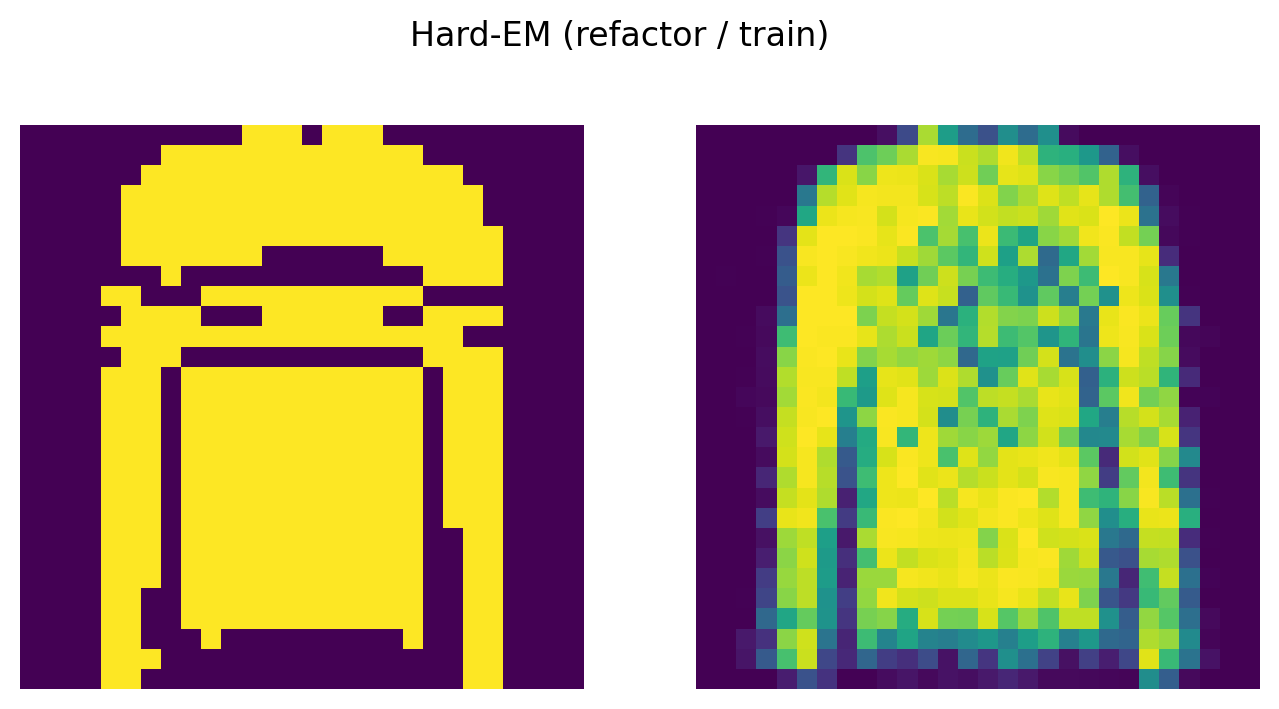

In [1530]:
state_final = res_hemv02["train"]["state_final"]
params_hemv2 = state_final.params
vals = model_hemv02.apply(params_hemv2, X_warmup, key)[1]

ix_target = 5
img_reconstruct = vals[ix_target].reshape(28, 28)
img_reconstruct = nn.sigmoid(img_reconstruct)

img_target = X_warmup[ix_target].reshape(28, 28)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img_target)
ax[1].imshow(img_reconstruct)

ax[0].axis("off")
ax[1].axis("off")

plt.suptitle("Hard-EM (refactor / train)")

In [1766]:
config_test_new = deepcopy(config_hemv02)
config_test_new.num_m_steps = 0
config_test_new.num_epochs = 1000
config_test_new.batch_size = len(X_test)

params_final = res_vae["train"]["state_final"].params
params_decoder_final = params_final["params"]["decoder"]

res_test = hlax.unamortised.test_decoder(key, config_test_new, X_test, iwae_bern_delta, params_decoder_final)
params_test = res_test["state"].params

  0%|          | 0/1000 [00:00<?, ?it/s]

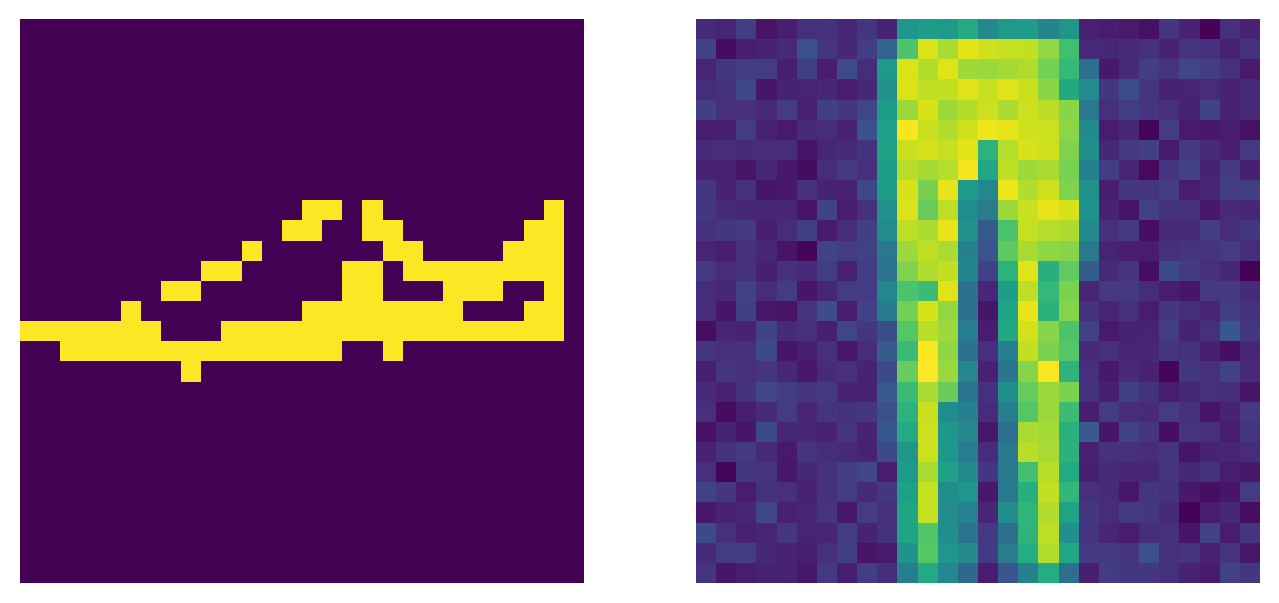

In [1767]:
ix_target = 9

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

img_truth = X_test[ix_target].reshape(28, 28)
img_reconstruct = config_test_new.model.apply(params_test, X_test, key)[1]
img_reconstruct = nn.sigmoid(img_reconstruct[ix_target]).reshape(28, 28)

ax[0].imshow(img_truth)
ax[1].imshow(img_reconstruct)

ax[0].axis("off")
ax[1].axis("off");

## Test phase

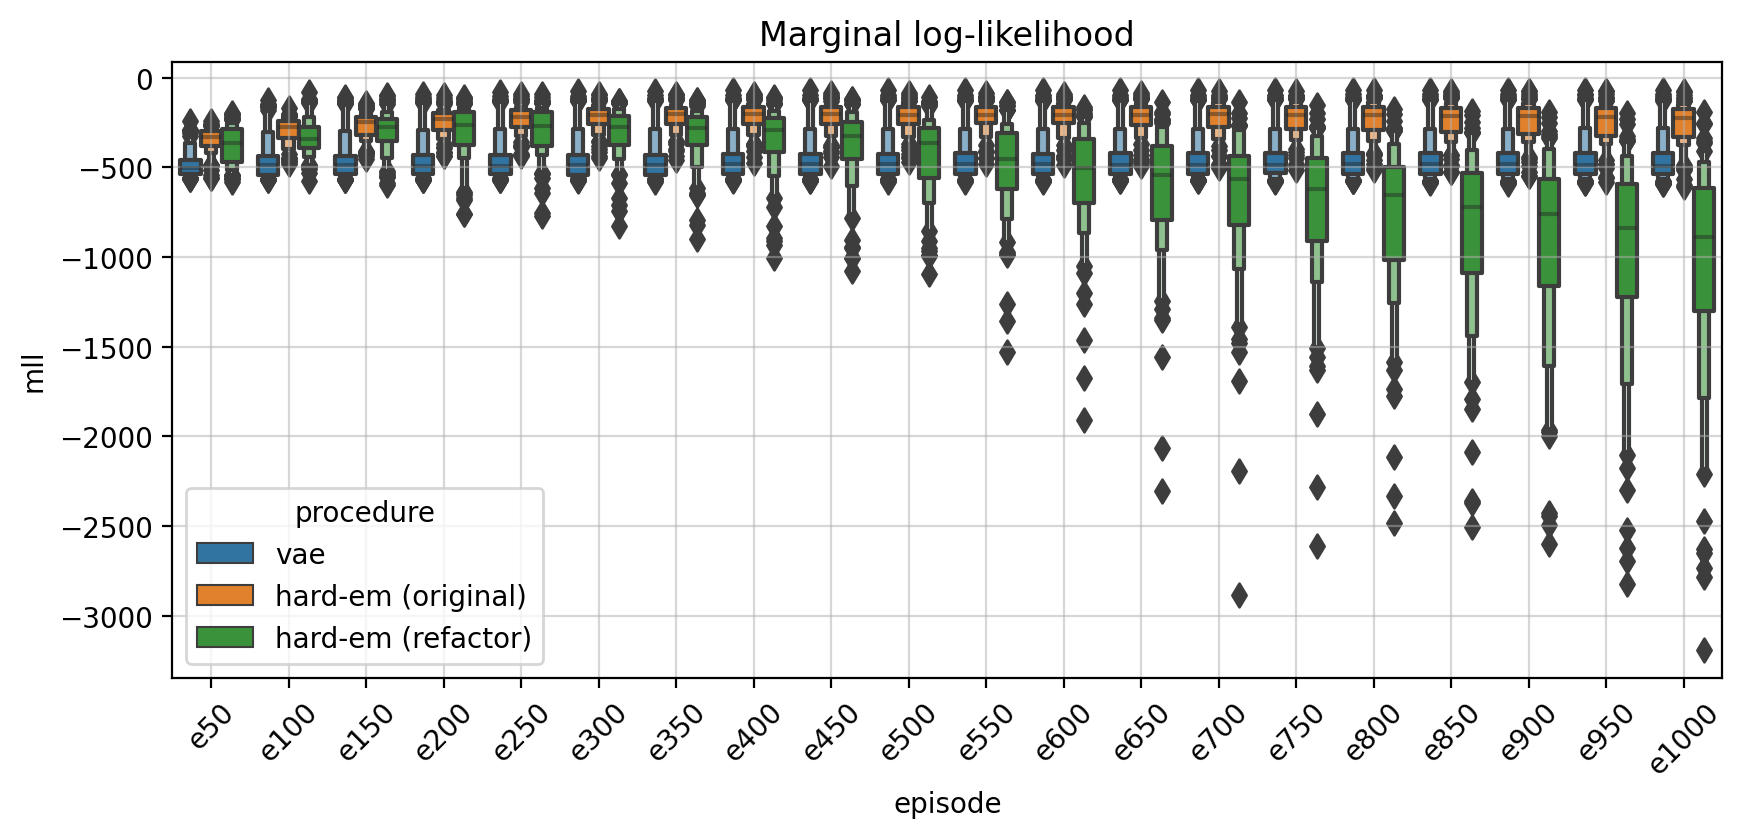

In [1534]:
df_uvae = build_mll_summary(res_uvae, "uvae")
df_vae = build_mll_summary(res_vae, "vae")
df_hem = build_mll_summary(res_hem, "hard-em (original)")
df_hemv02 = build_mll_summary(res_hemv02, "hard-em (refactor)")

# df_all = pd.concat([df_hem, df_vae, df_uvae, df_hemv02])
df_all = pd.concat([df_vae, df_hem, df_hemv02])
# df_all = pd.concat([df_hemv02, df_vae, df_uvae])
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxenplot(x="episode", y="mll", hue="procedure", data=df_all)
plt.title("Marginal log-likelihood")
plt.xticks(rotation=45)
plt.grid(alpha=0.5)
# plt.legend(bbox_to_anchor=(1.0, 1.0))

## Results

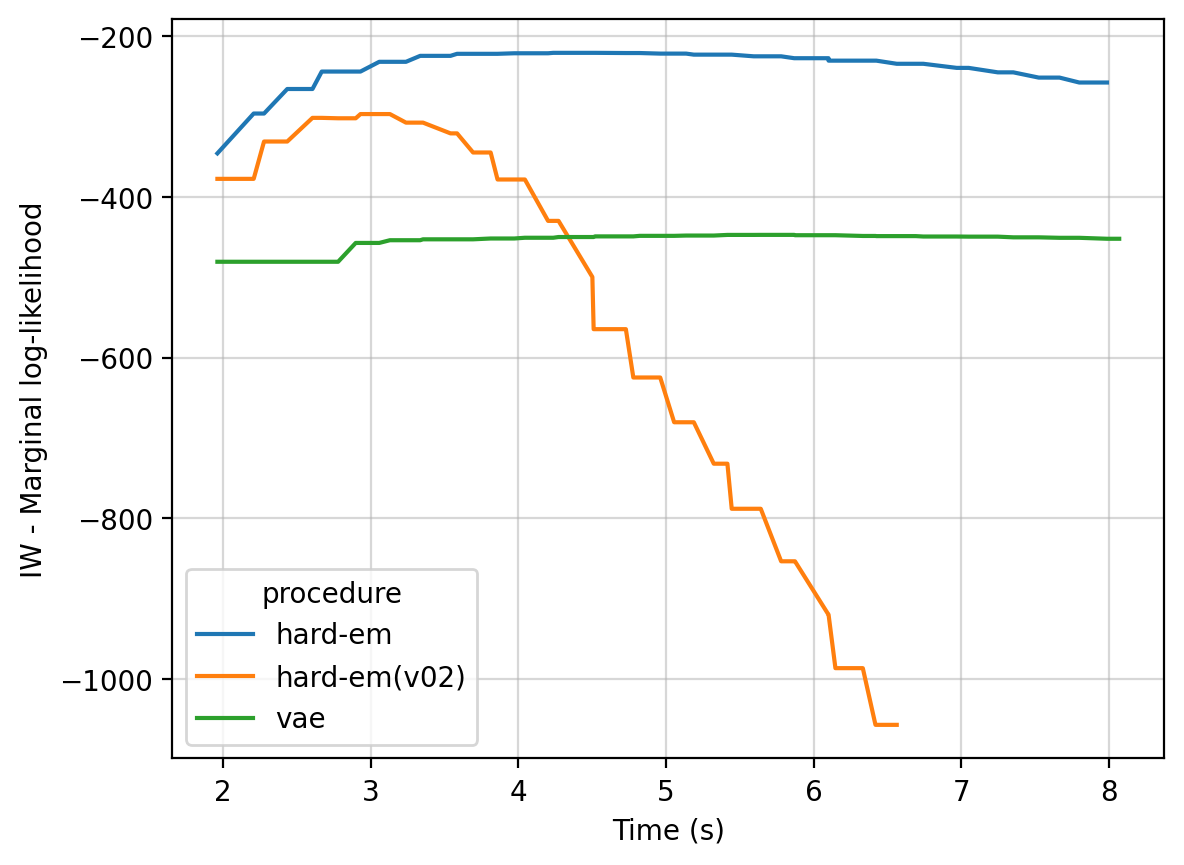

In [1532]:
df_all.pivot_table(index="times", columns="procedure", values="mll").bfill().plot()
plt.ylabel("IW - Marginal log-likelihood")
plt.xlabel("Time (s)")
plt.grid(alpha=0.5)

In [1608]:
nepoch = "e50"
res = res_vae

# Encoder params (found at test)
test_params_encoder = res["test"]["params"][nepoch]

# Decoder params (found at training)
test_params_decoder = res["train"]["checkpoint_params"][nepoch]

(-0.5, 27.5, 27.5, -0.5)

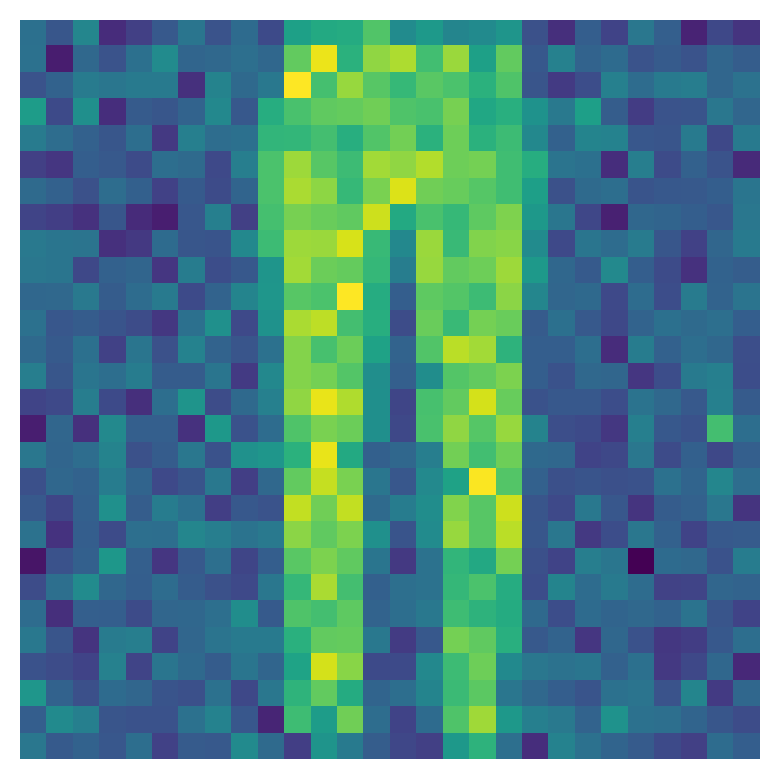

In [1609]:
ix_target = 1
mu = jax.vmap(config_test.model_encoder.apply, (0, None))(test_params_encoder, key)
mu = mu[-1][0]

logit_mean_x = config_test.model_decoder.apply(test_params_decoder, mu)

plt.imshow(nn.sigmoid(logit_mean_x[ix_target]).reshape(28, 28))
plt.axis("off")

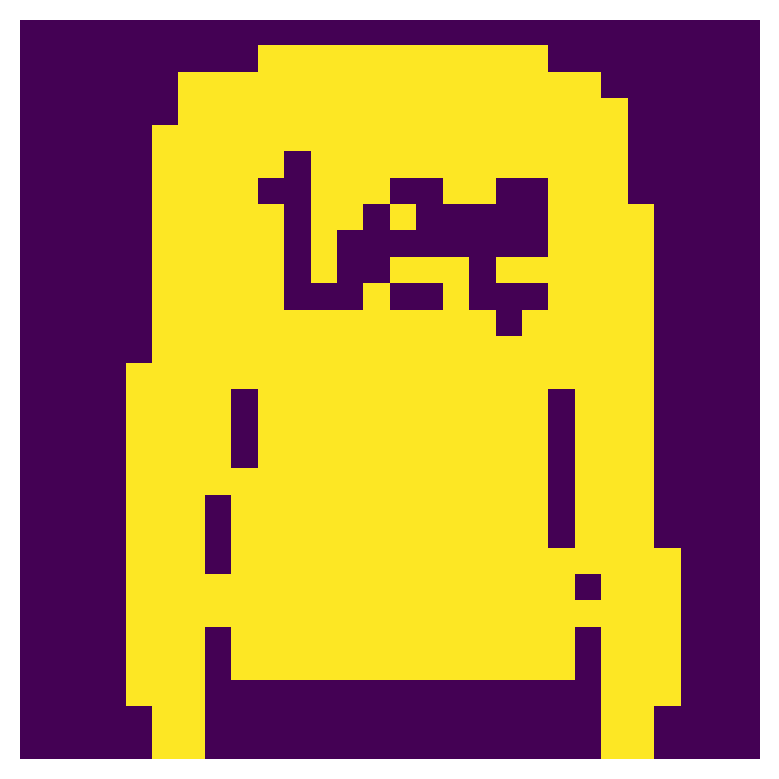

In [1610]:
plt.imshow(X_test[ix_target].reshape(28, 28))
plt.axis("off");